# Example 1

Dynamical system is
$$ \dot x = \begin{bmatrix} -2x_1 \\ -3(x_2 - x_1^2) \end{bmatrix} $$

In [1]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
import cvxpy as cp
import time

In [2]:
#Define Jacobian matrix E= dF(0)/dz at origin
E = np.array([[-2,0],[0,-3]])
# compute eigvalues and left eigenvectors of E
e,evecL,evecR = eig(E,left=True)
# eigenvalues
eval1 = e[0].real
eval2 = e[1].real
# eigenvectors
w1 = evecL[:,0]
w2 = evecL[:,1]

In [3]:
# Define (z_1,z_2) grid
npoints = 30
x_grid = np.linspace(-5, 5, npoints)
y_grid = np.linspace(-5, 5, npoints)

X,Y = np.meshgrid(x_grid,y_grid)
XY = np.zeros((npoints**2,2))

k = 0
for i in range(npoints):
    for j in range(npoints):
        XY[k,:] = np.array([X[i,j],Y[i,j]])
        k = k+1


# Define test grids
n_test = 60
x_grid_test = np.linspace(-5, 5, n_test)
y_grid_test = np.linspace(-5, 5, n_test)

X_test,Y_test = np.meshgrid(x_grid_test,y_grid_test)
XY_test = np.zeros((n_test**2,2))

k = 0
for i in range(n_test):
    for j in range(n_test):
        XY_test[k,:] = np.array([X_test[i,j],Y_test[i,j]])
        k = k+1

In [4]:
#Define functions F and G
def F(x):
    value1 = -2 * x[:,0]
    value2 = -3 * (x[:,1] - x[:,0]**2)
    return np.array([value1, value2]).T

def G(x):
    value = np.zeros((len(x),2))
    for i in range(len(x)):
        value[i,:] = np.dot(E, x[i,:])
    value = F(x)-value
    return value

In [5]:
# define eigenfunctions
def phi_1(X):
    return X[:,0]

def phi_2(X):
    return X[:,1] + 3 * X[:,0] ** 2

In [6]:
# copute F and G at mesh grids
F_val = F(XY)
G_val = G(XY)

#### Eigenfunction 1

In [7]:
# Generate random features
# number of features
N = 100
# scaling parameter
gamma = 0.1
start1 = time.time()
# random feature matrix
Omega = np.random.normal(0, np.sqrt(2*gamma), size=(2,N) )
# random bias
random_bias = np.random.uniform(-np.pi, np.pi, size=(N,))
# temp matrix
A_0 = np.cos(random_bias)
B_0 = np.sin(random_bias)
# generate amtrix A
A = np.zeros((npoints**2+3,N))
A[0,:] = A_0                   # h(0) = 0
A[1:3,:] = B_0 * Omega         # h'(0) = 0
# linear pde
A[3:,:] = - F_val @ Omega * np.sin(XY @ Omega + random_bias) - eval1 * np.cos(XY @ Omega + random_bias) 

# right-hand side
y0 = np.zeros((3,1))
y1 = np.zeros((npoints**2,1))
for i in range(npoints**2):
    y1[i] = -G_val[i,:] @ w1
y = np.row_stack((y0,y1))

# solve optimization problem
c = np.linalg.pinv(A) @ y
end1 = time.time()

In [8]:
# estimate non-linear function h at mesh grids
K = np.cos(XY_test @ Omega + random_bias)
y_test = K@c
# estimate eigenfunction
phi1_hat = y_test.reshape(n_test,n_test) + w1[0] * X_test + w1[1] * Y_test
# compute true eigenfucntion
phi1 = phi_1(XY_test).reshape(n_test,n_test)

# test error
test_error = np.mean( (phi1_hat - phi1) ** 2 )
print(f'Average test error is {test_error:.2e}')

# relative test error
rel_error = np.sum((phi1_hat - phi1) ** 2) / np.sum(phi1**2)
print(f'Relative test error is {rel_error:.2e}')

Average test error is 0.00e+00
Relative test error is 0.00e+00


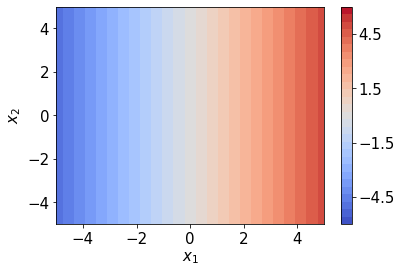

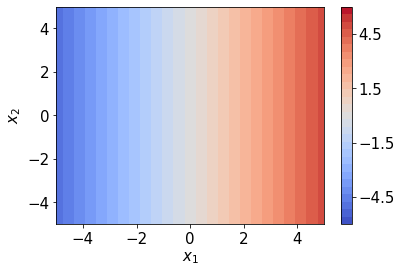

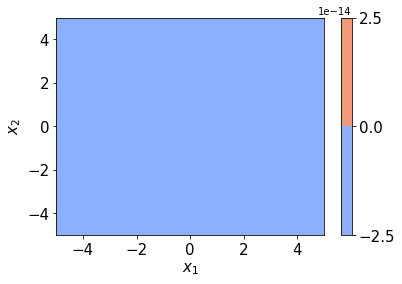

In [9]:
# visualization
plt.figure(1)
im = plt.contourf(X_test,Y_test,phi1_hat, levels=np.linspace(-6,6,30),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[-4.5, -1.5, 1.5, 4.5])
cbar.ax.tick_params(labelsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig1.pdf', bbox_inches = 'tight')

plt.figure(2)
im = plt.contourf(X_test,Y_test,phi1, levels=np.linspace(-6,6,30),cmap="coolwarm")
cbar = plt.colorbar(im,ticks=[-4.5, -1.5, 1.5, 4.5])
cbar.ax.tick_params(labelsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig1_true.pdf', bbox_inches = 'tight')

#plt.figure(3)
#im = plt.contourf(X_test,Y_test,abs(phi1-phi1_hat),cmap="coolwarm")
#cbar = plt.colorbar(im)
#cbar.ax.tick_params(labelsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.xlabel(r'$x_1$', fontsize=15)
#plt.ylabel(r'$x_2$', fontsize=15)
#plt.savefig('eig1_err.pdf', bbox_inches = 'tight')

#### Eigenfunction 2

In [10]:
# Generate random features
# number of features
N = 100
# scaling parameter
gamma = 0.1
start2 = time.time()
# random feature matrix
Omega = np.random.normal(0, np.sqrt(2*gamma), size=(2,N) )
# random bias
random_bias = np.random.uniform(-np.pi, np.pi, size=(N,))
# temp matrix
A_0 = np.cos(random_bias)
B_0 = np.sin(random_bias)
# generate amtrix A
A = np.zeros((npoints**2+3,N))
A[0,:] = A_0                   # h(0) = 0
A[1:3,:] = B_0 * Omega         # h'(0) = 0
# linear pde
A[3:,:] = - F_val @ Omega * np.sin(XY @ Omega + random_bias) - eval2 * np.cos(XY @ Omega + random_bias) 

# right-hand side
y0 = np.zeros((3,1))
y1 = np.zeros((npoints**2,1))
for i in range(npoints**2):
    y1[i] = -G_val[i,:] @ w2
y = np.row_stack((y0,y1))

# solve optimization problem
c = np.linalg.pinv(A) @ y
end2 = time.time()

In [11]:
# estimate non-linear function h at mesh grids
K = np.cos(XY_test @ Omega + random_bias)
y_test = K@c

# estimate eigenfunction
phi2_hat = y_test.reshape(n_test,n_test) + w2[0] * X_test + w2[1] * Y_test
# compute true eigenfucntion
phi2 = phi_2(XY_test).reshape(n_test,n_test)

# test error
test_error = np.mean( (phi2_hat - phi2) ** 2 )
print(f'Average test error is {test_error:.2e}')

# relative test error
rel_error = np.sum((phi2_hat - phi2) ** 2) / np.sum(phi2**2)
print(f'Relative test error is {rel_error:.2e}')

Average test error is 8.61e-10
Relative test error is 7.11e-13


In [12]:
# computational time
print(f'{end2-start2+end1-start1:.2f} seconds')

0.02 seconds


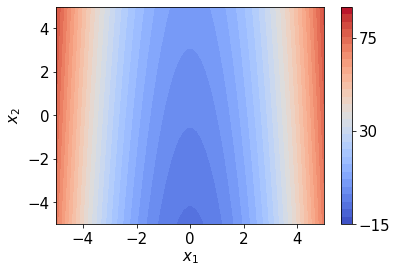

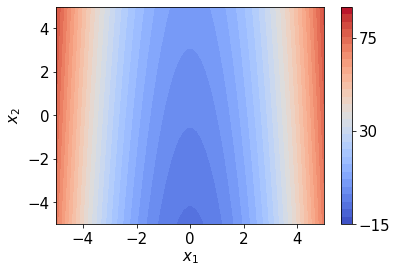

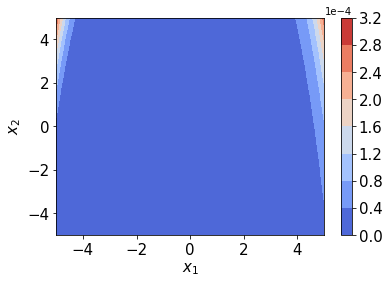

In [13]:
# visualization
## prediction
plt.figure(1)
im = plt.contourf(X_test,Y_test,phi2_hat,levels=np.linspace(-15,90,30),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[-15,30,75])
cbar.ax.tick_params(labelsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig2.pdf', bbox_inches = 'tight')


## true 
plt.figure(2)
im = plt.contourf(X_test,Y_test,phi2,levels=np.linspace(-15,90,30),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[-15,30,75])
cbar.ax.tick_params(labelsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig2_true.pdf', bbox_inches = 'tight')

#plt.figure(3)
#im = plt.contourf(X_test,Y_test,abs(phi2-phi2_hat),cmap="coolwarm")
#cbar = plt.colorbar(im)
#cbar.ax.tick_params(labelsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.xlabel(r'$x_1$', fontsize=15)
#plt.ylabel(r'$x_2$', fontsize=15)
#plt.savefig('eig2_err.pdf', bbox_inches = 'tight')

## Lyapunov Function

In [14]:
# solve for P
P = cp.Variable((2,2),nonneg=True)
objective = cp.Minimize(1)
constraint = [cp.multiply(E,P) + cp.multiply(P,E) << 0]
sdp1 = cp.Problem(objective, constraint)
sdp1.solve()
P = P.value

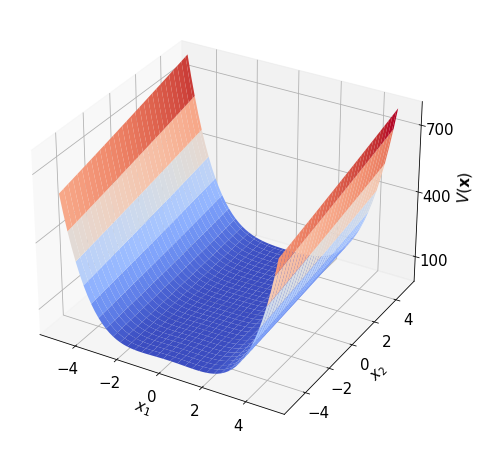

In [15]:
# Compute Lyapunov function
V_hat = P[0,0] * phi1_hat**2 + P[1,1] * phi2_hat**2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X_test, Y_test, V_hat, cmap = 'coolwarm')
ax.set_zticks([100,400,700])
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.set_zlabel(r'$V(\mathbf{x})$', fontsize=15,labelpad=8)
plt.savefig('Lya_hat.pdf', bbox_inches = 'tight')

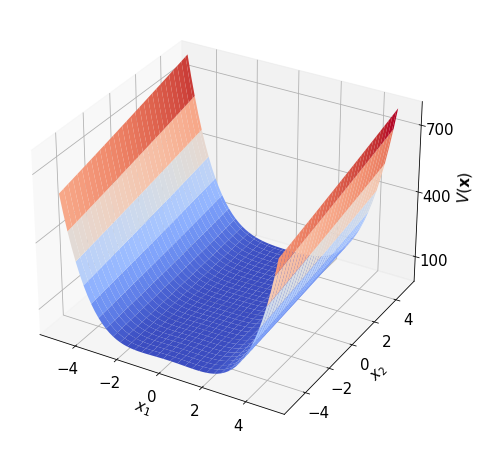

In [16]:
# Compute Lyapunov function
V = P[0,0] * phi1**2 + P[1,1] * phi2**2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X_test, Y_test, V, cmap = 'coolwarm')
ax.set_zticks([100,400,700])
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.set_zlabel(r'$V(\mathbf{x})$', fontsize=15,labelpad=8)
plt.savefig('Lya_true.pdf', bbox_inches = 'tight')

In [17]:
# Test error 
test_err = np.mean((V_hat - V)**2)
print(f'Average test error is {test_err:.2e}')
# Relative test error
rel_err = np.sum((V_hat - V)**2) / np.sum(V**2)
print(f'Relative test error is {rel_err:.2e}')

Average test error is 2.68e-07
Relative test error is 4.33e-12


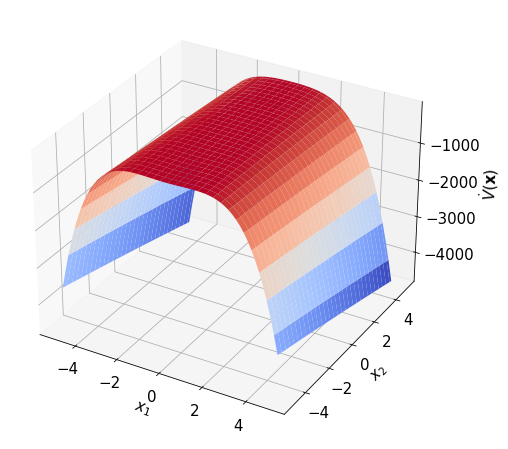

In [18]:
# Compute Lyapunov function V^.
V_dot_hat = 2* eval1 * P[0,0] * phi1_hat**2 + 2*eval2*P[1,1] * phi2_hat**2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X_test, Y_test, V_dot_hat ,cmap = 'coolwarm')
ax.tick_params(labelsize=15)
ax.tick_params(axis='z', pad=13)
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.set_zlabel(r'$\dotV(\mathbf{x})$', fontsize=15,labelpad=23)
plt.savefig('Lya_dot_hat.pdf', bbox_inches = 'tight')

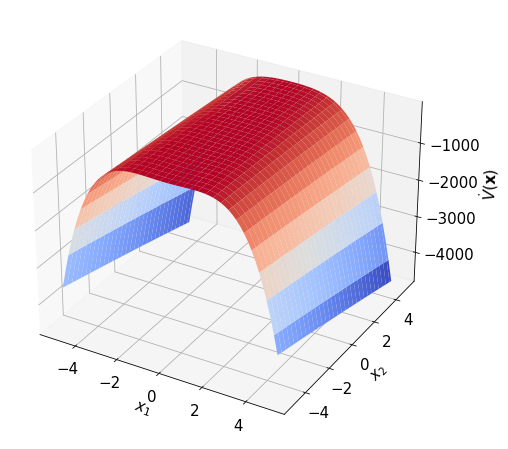

In [19]:
# Compute Lyapunov function V^.
V_dot = 2* eval1 * P[0,0] * phi1**2 + 2*eval2*P[1,1] * phi2**2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X_test, Y_test, V_dot ,cmap = 'coolwarm')
ax.tick_params(labelsize=15)
ax.tick_params(axis='z', pad=13)
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.set_zlabel(r'$\dotV(\mathbf{x})$', fontsize=15,labelpad=23)
plt.savefig('Lya_dot.pdf', bbox_inches = 'tight')

In [20]:
# 
test_err = np.mean((V_dot_hat - V_dot)**2)
print(f'Average test error is {test_err:.2e}')
# Relative test error
rel_err = np.sum((V_dot_hat - V_dot)**2) / np.sum(V_dot**2)
print(f'Relative test error is {rel_err:.2e}')

Average test error is 9.64e-06
Relative test error is 4.35e-12
